In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
import scipy
scipy.__version__

'1.3.1'

In [4]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import lightkurve as lk

In [5]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [6]:
# Guesses from search
periods = np.array([17.47114])
t0s = np.array([1661.0628])
depths = 1e3 * np.array([0.0328])**2
durations = np.array([3.0]) / 24.0
letters = "bcd"

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


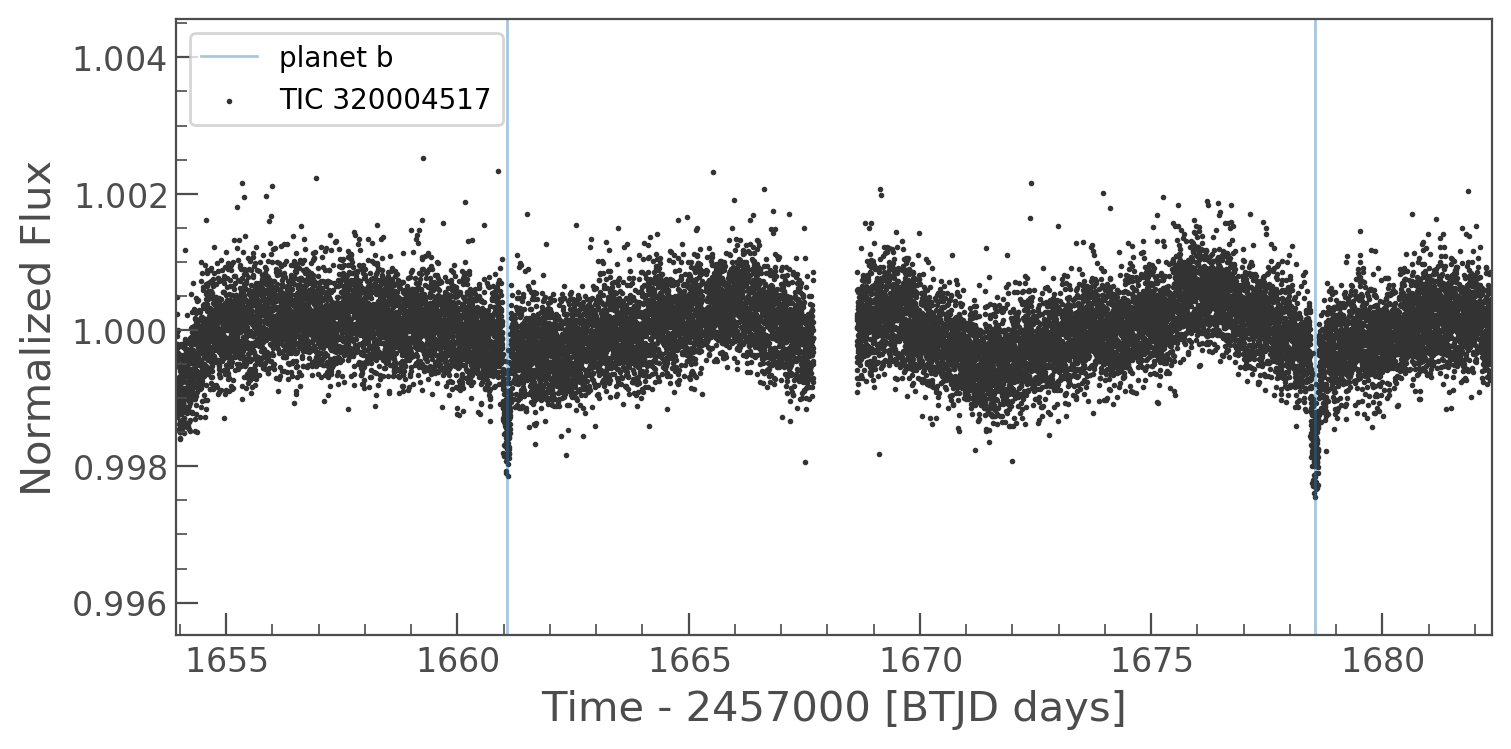

In [7]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC {0}'.format(tic_id))
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in np.arange(mn, mx + 1):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

In [8]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


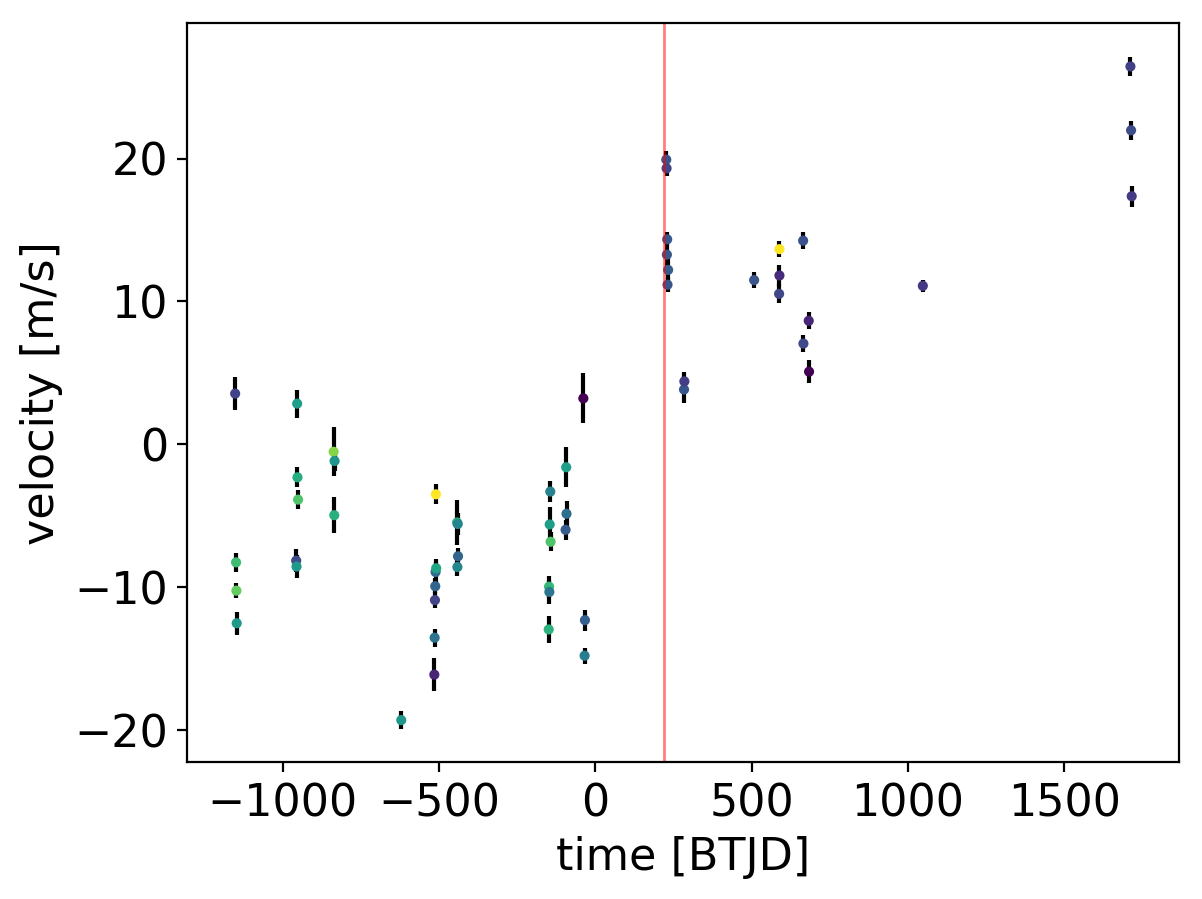

In [9]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
#df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)

t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv[~pug], y_rv[~pug], c=df.bis[~pug], s=7)
plt.scatter(x_rv[pug], y_rv[pug], c=df.bis[pug], s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

In [10]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[5.00285191] earthMass


In [11]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None, bis=True):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        log_period = pm.Normal("log_period", mu=np.log(periods[0]), sd=10.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0)
        
        log_ror = pm.Uniform("log_ror", lower=np.log(0.01), upper=np.log(0.1),
                             testval=0.5*np.log(1e-3*depths[0]))
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b_hat = xo.distributions.UnitUniform("b_hat")
        b = pm.Deterministic("b", b_hat * (1 + ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value[0]), sd=5)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.UnitUniform("ecc", testval=0.01)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        
        # RV jitter & a quadratic RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)
        if bis:
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        model.light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) + mean_flux

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", model.gp.log_likelihood(y[mask] - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, 3)
        if bis:
            A_bis = np.vander(bis_rv, 3)
            bkg = pm.Deterministic("bkg", tt.dot(A, trend) + tt.dot(A_bis, trend_bis) + pug*offset_pug)
        else:
            bkg = pm.Deterministic("bkg", tt.dot(A, trend) + pug*offset_pug)

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv, 3)
        pug_pred = t_rv >= HARPS_upgrade
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend) + pug_pred*offset_pug)
        pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [12]:
model, map_soln = build_model(bis=True)

optimizing logp for variables: ['logs2']
9it [00:01,  8.76it/s, logp=-1.267704e+04] 
message: Optimization terminated successfully.
logp: -13361.147029837955 -> -12677.040527322384
optimizing logp for variables: ['offset_pug', 'trend', 'logs_rv_pug', 'logs_rv_pre']
59it [00:00, 82.78it/s, logp=-1.106523e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12677.040527322384 -> -11065.227699124625
optimizing logp for variables: ['trend_bis']
11it [00:00, 22.19it/s, logp=-1.106435e+04] 
message: Optimization terminated successfully.
logp: -11065.227699124625 -> -11064.352621282604
optimizing logp for variables: ['b_hat_logodds__', 'log_ror_interval__']
10it [00:00, 14.34it/s, logp=-1.103495e+04]
message: Optimization terminated successfully.
logp: -11064.3526212826 -> -11034.951710151923
optimizing logp for variables: ['t0_interval__', 'log_period']
17it [00:00, 32.04it/s, logp=-1.103469e+04] 
message: Optimization terminated successfully.
logp: -11034.9517

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


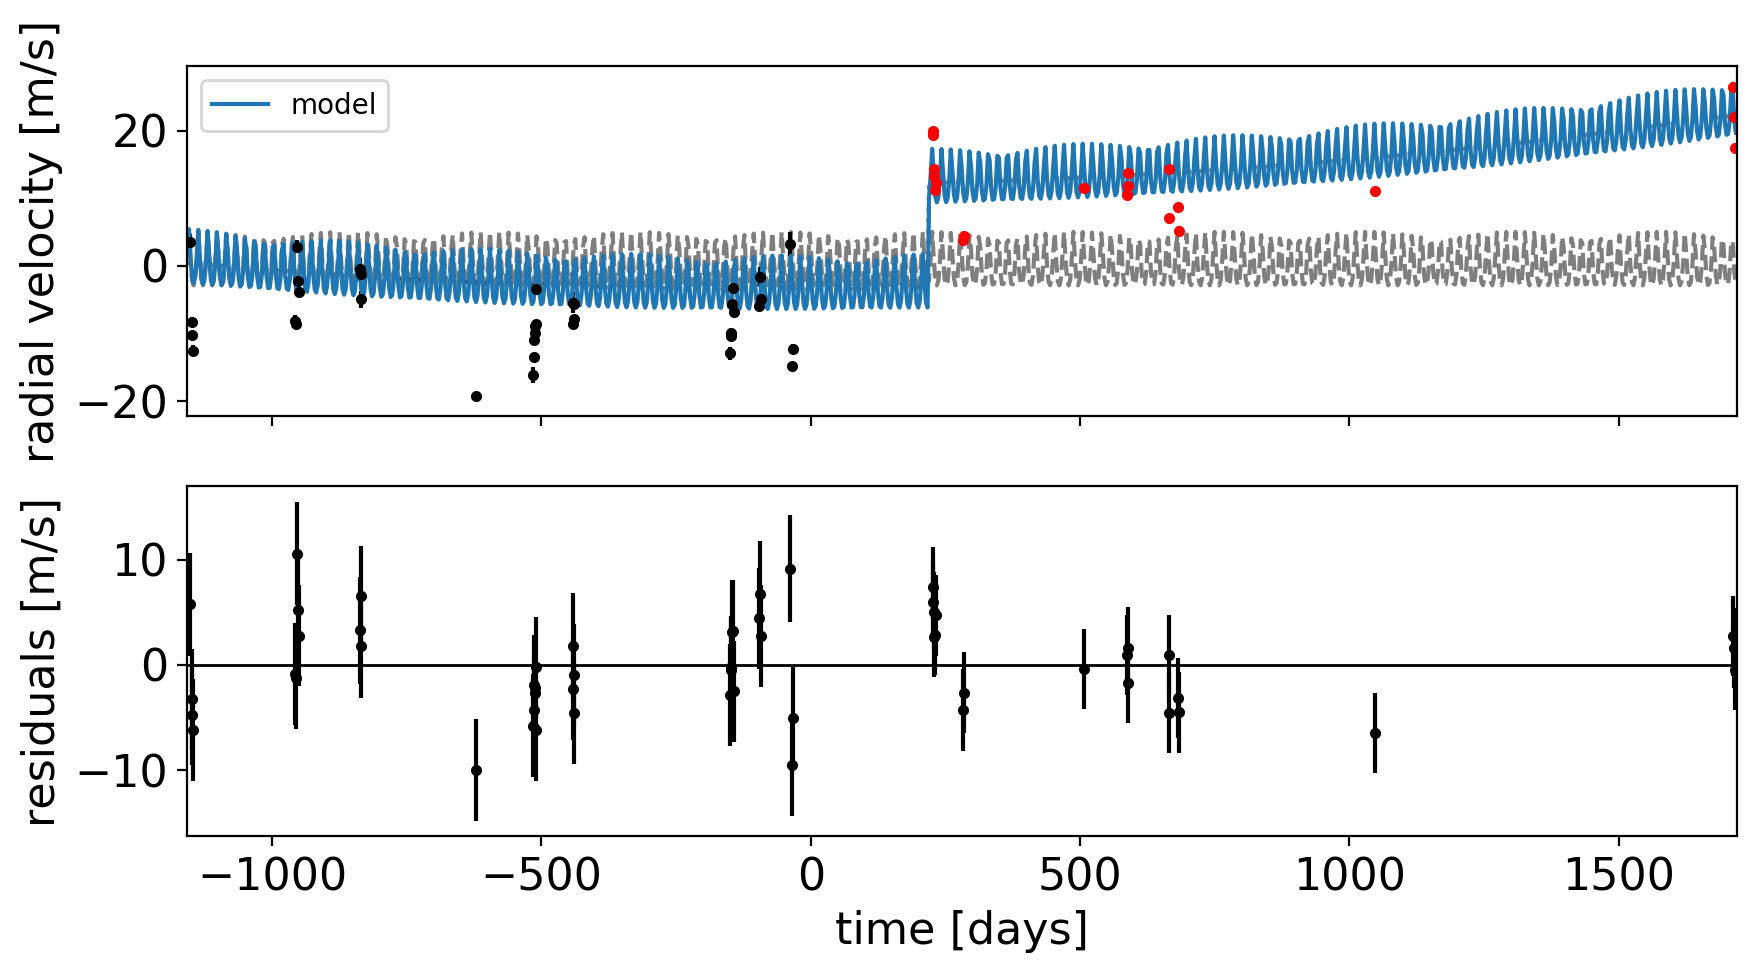

In [13]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv[~pug], y_rv[~pug], yerr=yerr_rv[~pug], fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug], yerr=yerr_rv[pug], fmt=".r")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err_pre = np.sqrt(yerr_rv[~pug]**2+np.exp(2*soln["logs_rv_pre"]))
    err_pug = np.sqrt(yerr_rv[pug]**2+np.exp(2*soln["logs_rv_pug"]))
    ax.errorbar(x_rv[~pug], y_rv[~pug] - soln["rv_model"][~pug], yerr=err_pre, fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug] - soln["rv_model"][pug], yerr=err_pug, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min() - 50, t_rv.max() + 50)
    ax.set_xlabel("time [days]")

plot_rv_curve(map_soln)

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


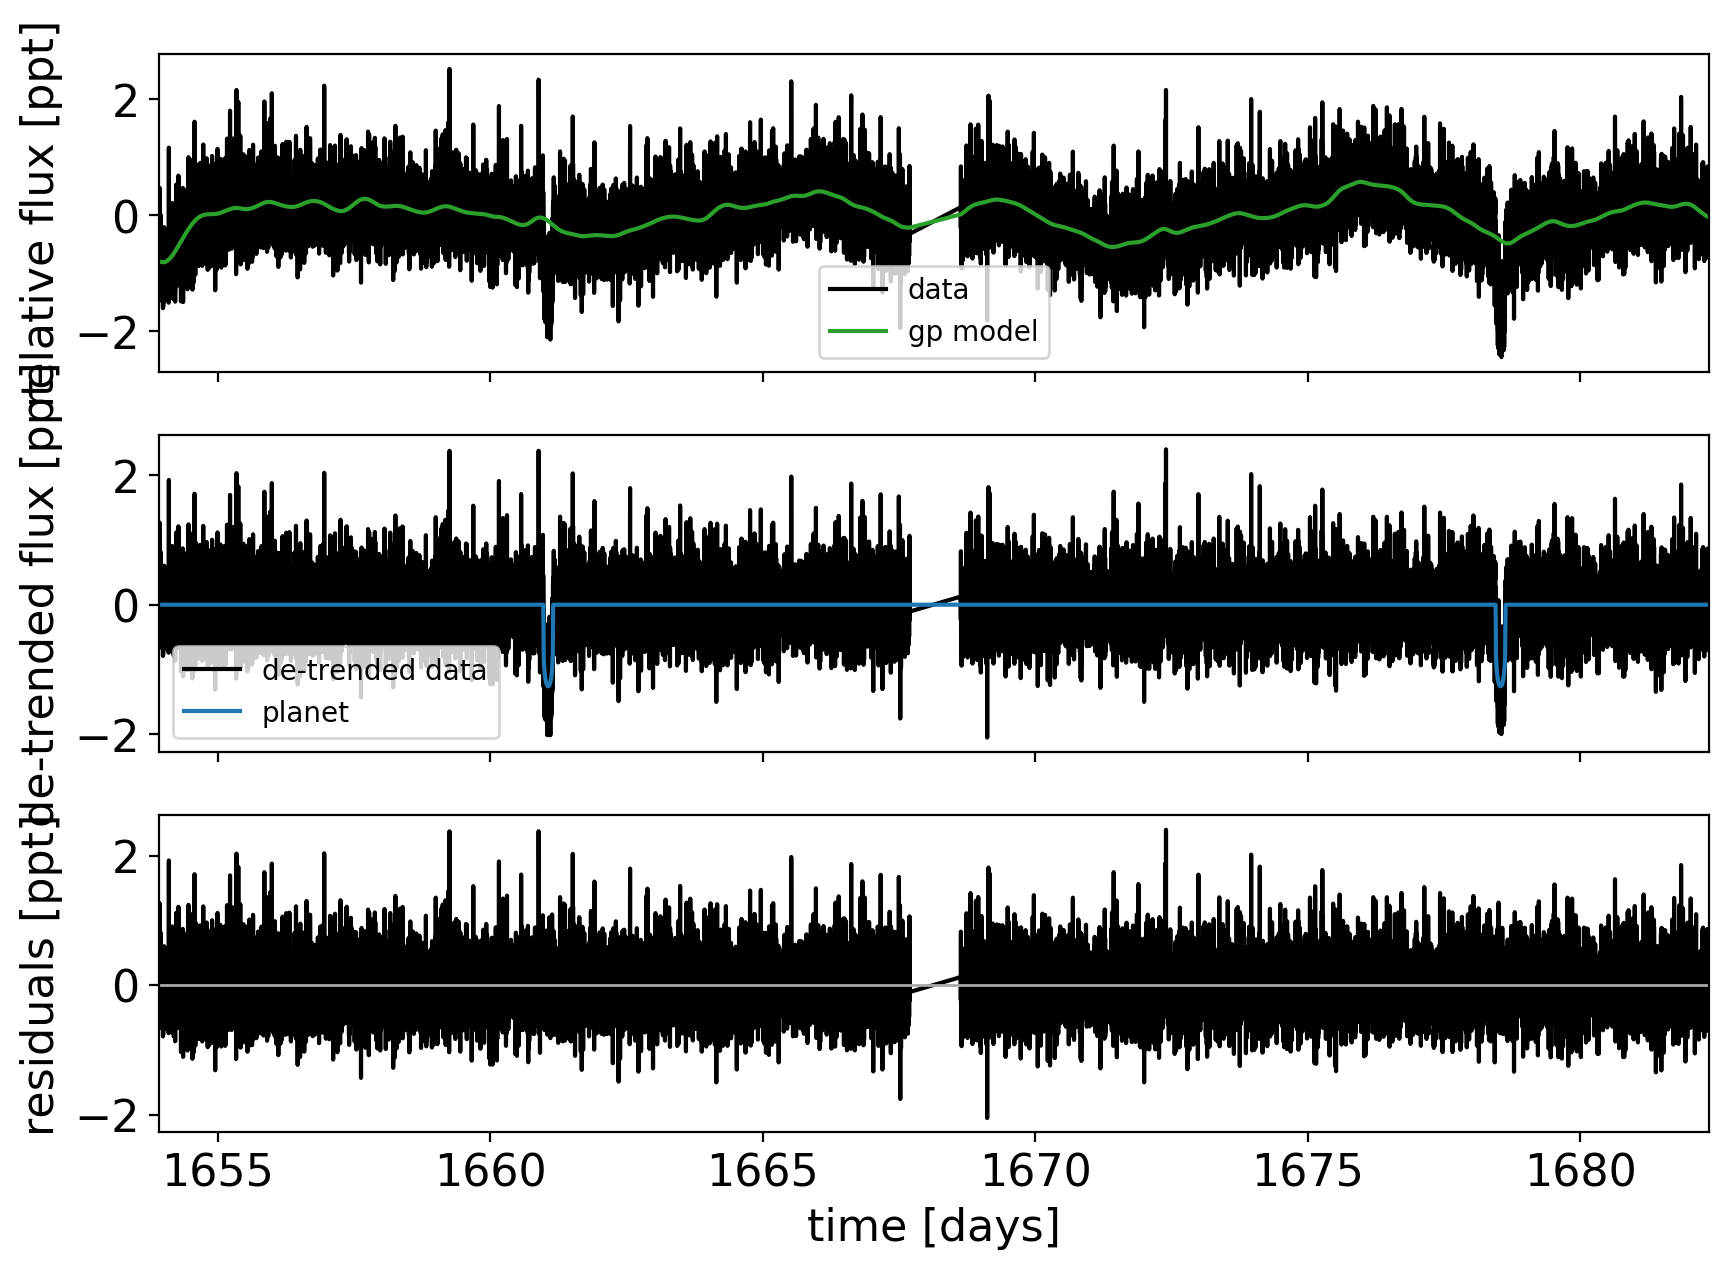

In [14]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], soln)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    ax.plot(x[mask], lc_mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + lc_mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(model, map_soln);

Text(0,0.5,'rv residuals')

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


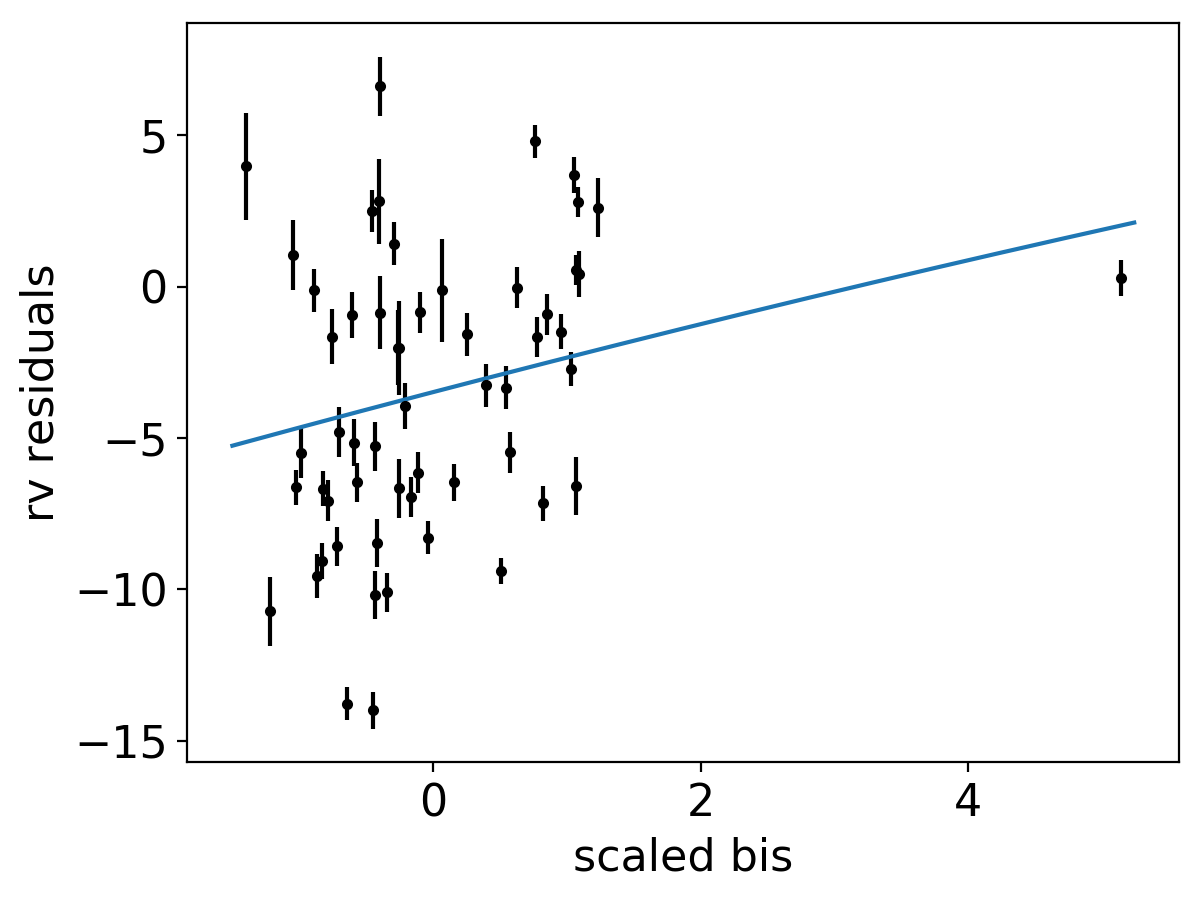

In [15]:
bkg_bis0 = np.dot(np.vander(bis_rv, 3), map_soln["trend_bis"])

bis_test = np.linspace(bis_rv.min() - 0.1, bis_rv.max() + 0.1, 5000)
bkg_bis = np.dot(np.vander(bis_test, 3), map_soln["trend_bis"])

plt.errorbar(bis_rv, y_rv - map_soln["rv_model"] + bkg_bis0, yerr=yerr_rv, fmt=".k")
plt.plot(bis_test, bkg_bis)
plt.xlabel("scaled bis")
plt.ylabel("rv residuals")

In [16]:
np.random.seed(123)
with model:
    trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend_bis, trend, offset_pug, logs_rv_pug, logs_rv_pre, logpower, logw0, logs2, omega, ecc, log_m_pl, b_hat, log_ror, t0, log_period, u_star, mean_flux, mr_star]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:30<00:00,  3.16draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


In [17]:
pm.summary(trace, varnames=[k for k in trace.varnames if not k.endswith("__") and not k in ("vrad", "vrad_pred", "bkg", "rv_model", "rv_model_pred", "bkg_pred")])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean_flux,-0.016690,0.067640,2.465340e-03,-0.147969,0.117633,400.355690,1.007573
log_period,2.860557,0.000089,2.336988e-06,2.860369,2.860714,1265.463714,1.000740
logs2,-1.751670,0.009818,2.388493e-04,-1.771402,-1.733794,1995.252116,0.999738
logw0,0.739535,0.160497,4.467590e-03,0.416396,1.042858,1253.253904,0.999538
logpower,0.043250,0.314703,7.191826e-03,-0.548380,0.666999,1780.531276,0.999766
logs_rv_pre,1.598452,0.124699,3.375738e-03,1.361264,1.829985,1000.695185,0.999543
logs_rv_pug,1.491696,0.181590,5.536975e-03,1.152752,1.839397,811.067299,1.001662
offset_pug,15.465920,0.418663,1.191628e-02,14.724483,16.331419,1198.320479,0.999500
trend__0,0.000003,0.000001,3.245354e-08,0.000001,0.000005,812.639557,1.001717
trend__1,0.000890,0.001199,3.275976e-05,-0.001532,0.003142,1248.652830,1.000753


/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


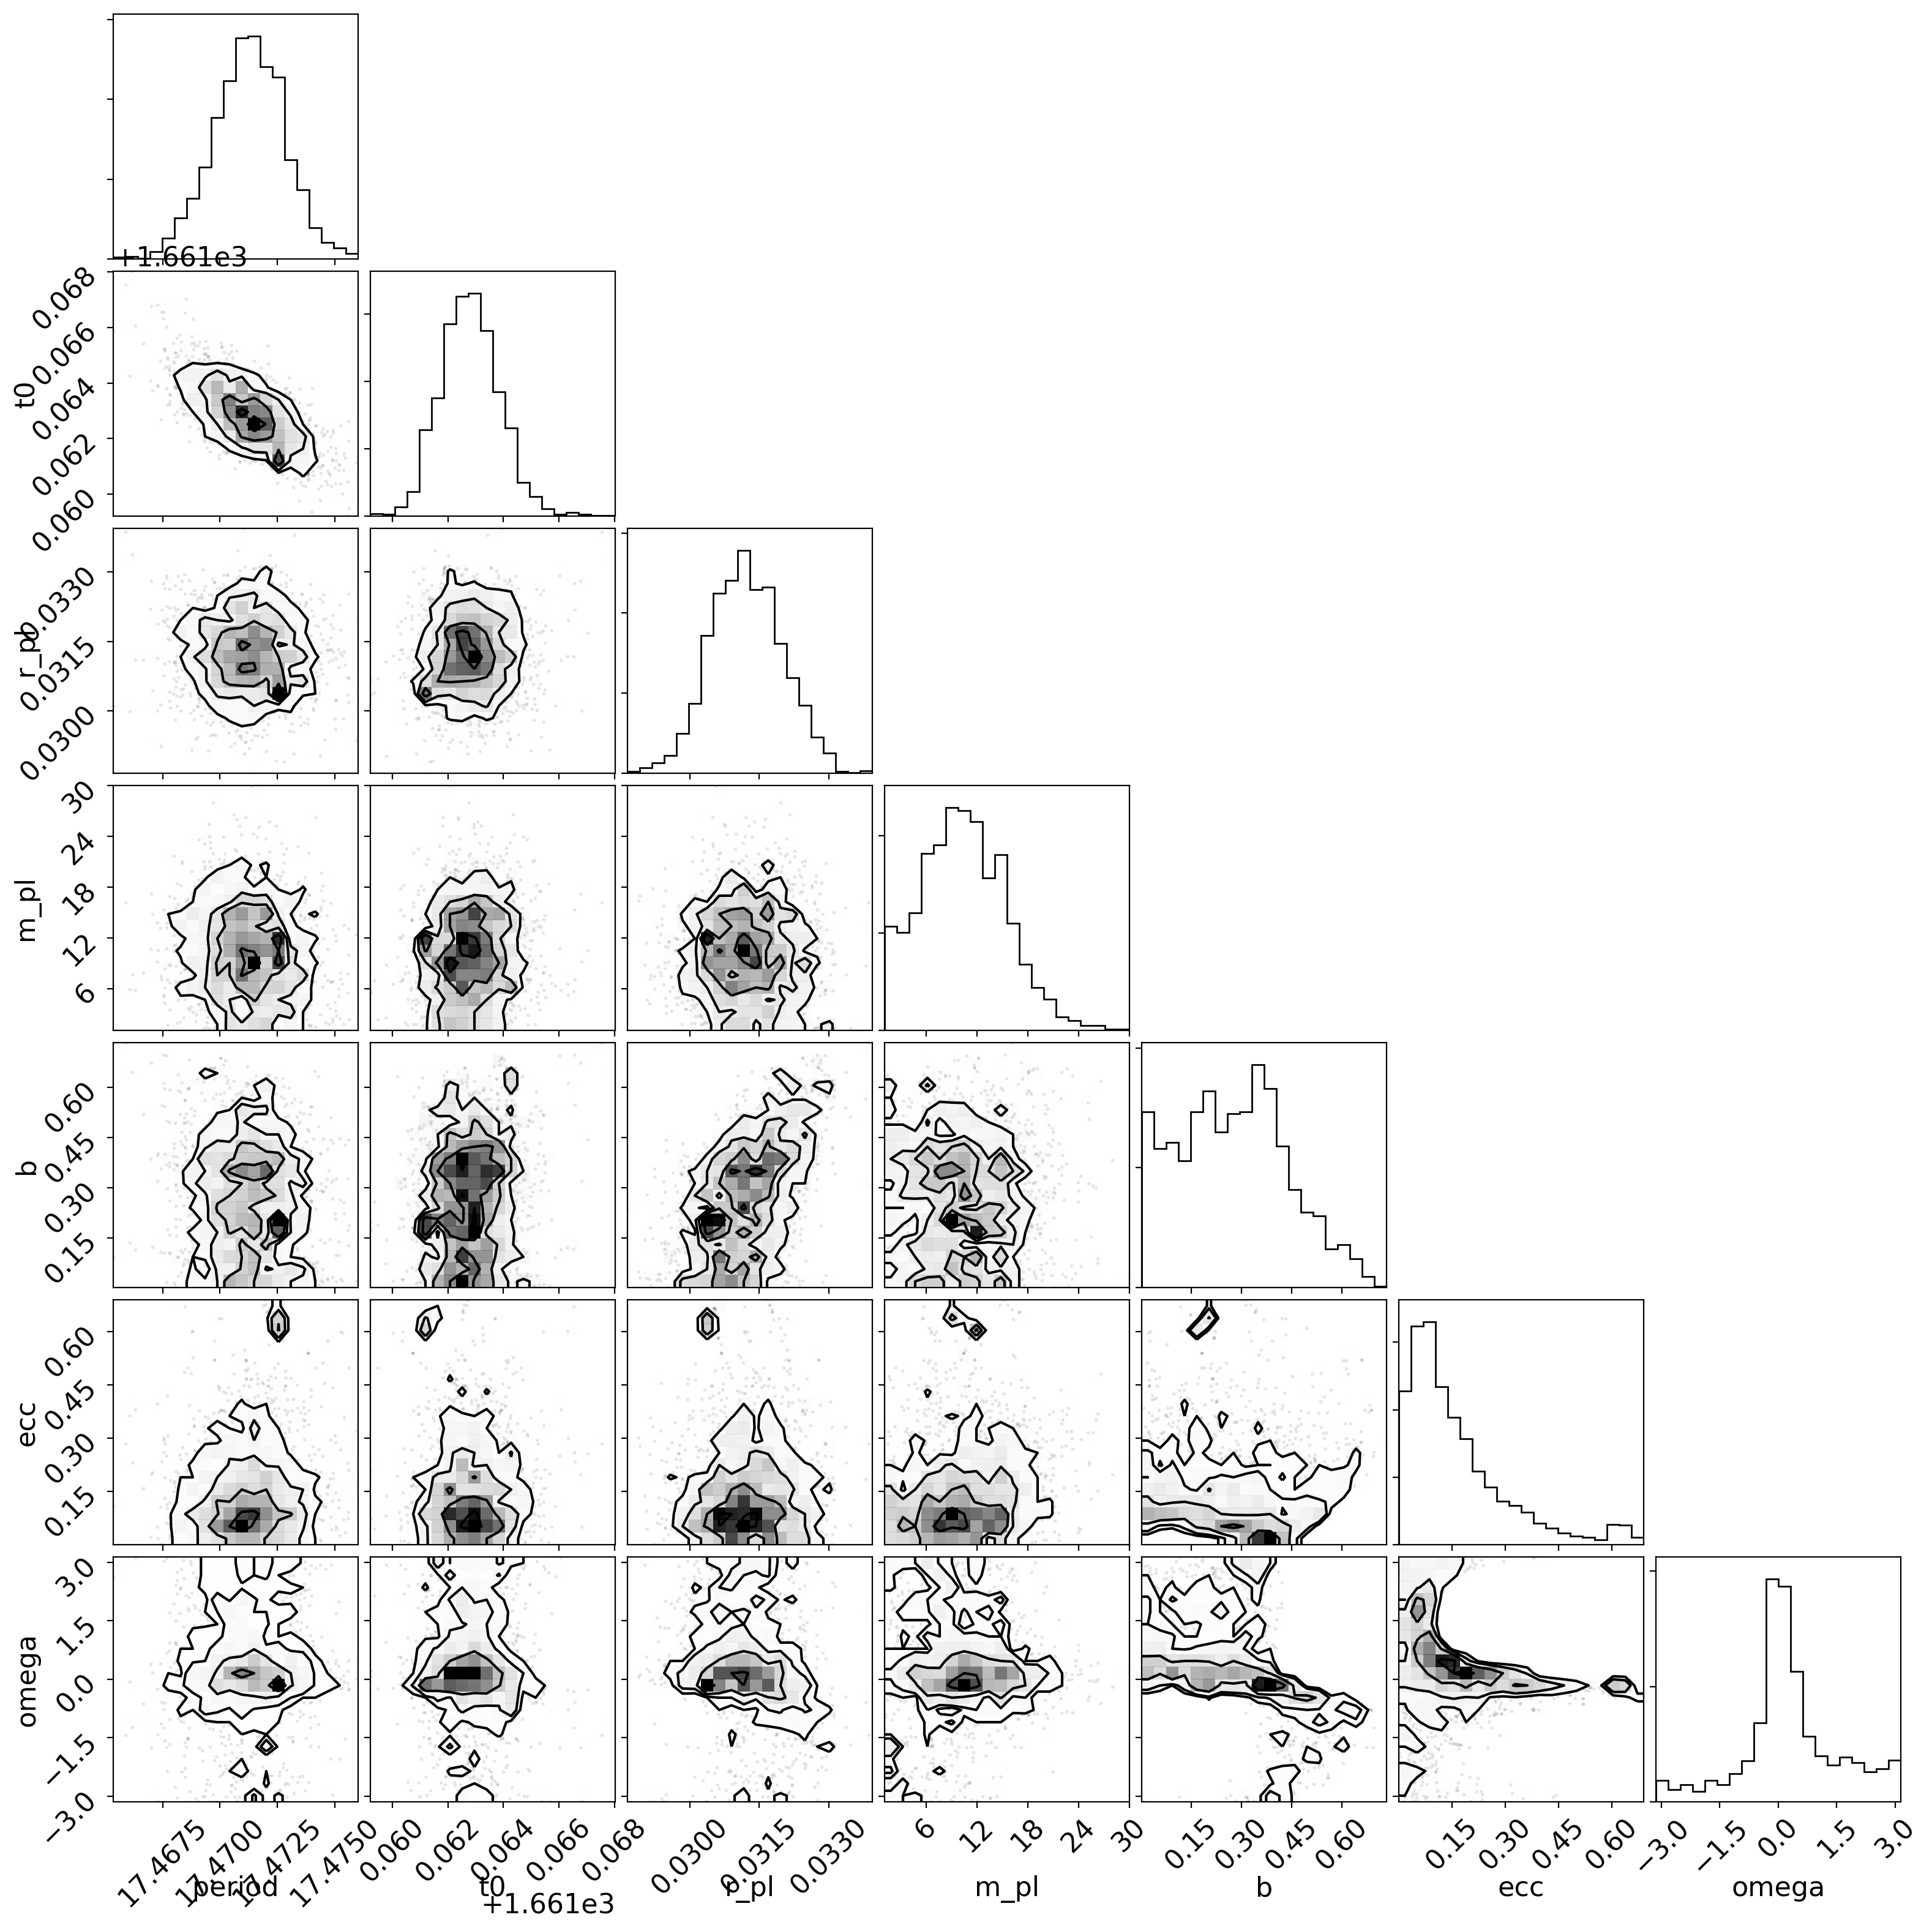

In [18]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


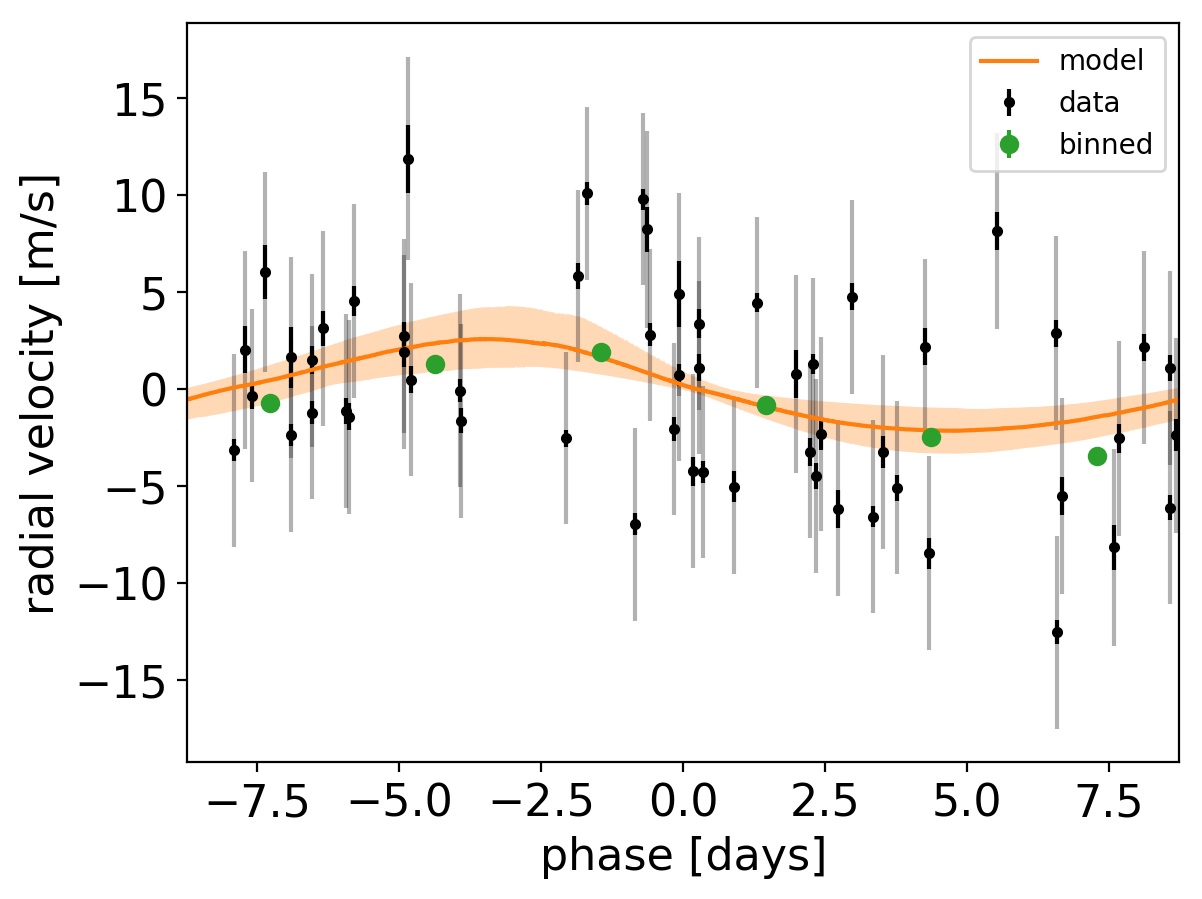

In [19]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");